In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import joblib


In [28]:
df = pd.read_csv("data/medicine_price_dataset.csv")
df.head()


,medicine_id,medicine_name,category,company,dosage_mg,pack_size,manufacturing_cost,import_status,demand_level,expiry_months,prescription_required,price
0,1,Napa,Injection,Renata,500,1,147.61,Local,Low,12,1,199.33
1,2,Ace,Tablet,Incepta,500,5,106.09,Local,Low,18,0,146.89
2,3,Paracetamol,Capsule,NovoNordisk,100,5,59.57,Local,Low,16,1,109.10
3,4,Ace,Tablet,Square,100,1,119.89,Local,Medium,33,0,220.83
4,5,Ace,Syrup,NovoNordisk,1000,20,92.61,Imported,Low,36,1,247.41


In [29]:
if "medicine_id" in df.columns:
    df.drop("medicine_id", axis=1, inplace=True)
df.columns


Index(['medicine_name', 'category', 'company', 'dosage_mg', 'pack_size',
       'manufacturing_cost', 'import_status', 'demand_level', 'expiry_months',
       'prescription_required', 'price'],
      dtype='object')

In [30]:
df.info()
df.isnull().sum()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   medicine_name          5000 non-null   object 
 1   category               5000 non-null   object 
 2   company                5000 non-null   object 
 3   dosage_mg              5000 non-null   int64  
 4   pack_size              5000 non-null   int64  
 5   manufacturing_cost     5000 non-null   float64
 6   import_status          5000 non-null   object 
 7   demand_level           5000 non-null   object 
 8   expiry_months          5000 non-null   int64  
 9   prescription_required  5000 non-null   int64  
 10  price                  5000 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 429.8+ KB


,dosage_mg,pack_size,manufacturing_cost,expiry_months,prescription_required,price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,378.550000,9.167400,105.051410,21.085000,0.504600,263.385106
std,344.146894,7.079138,54.630089,8.968069,0.500029,125.922879
min,50.000000,1.000000,10.040000,6.000000,0.000000,15.400000
25%,100.000000,5.000000,58.237500,13.000000,0.000000,169.170000
50%,250.000000,10.000000,105.170000,21.000000,1.000000,254.075000
75%,500.000000,20.000000,152.180000,29.000000,1.000000,350.642500
max,1000.000000,20.000000,199.970000,36.000000,1.000000,653.880000


In [31]:
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df["price"] >= lower) & (df["price"] <= upper)]


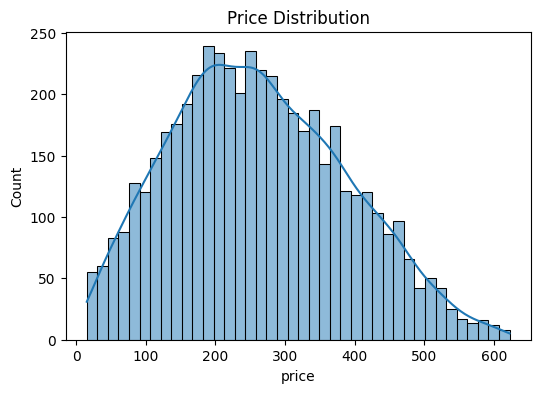

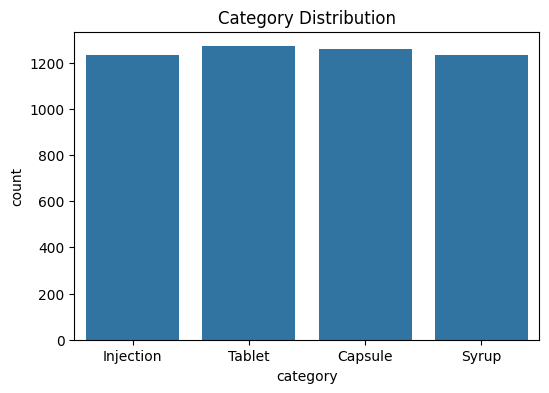

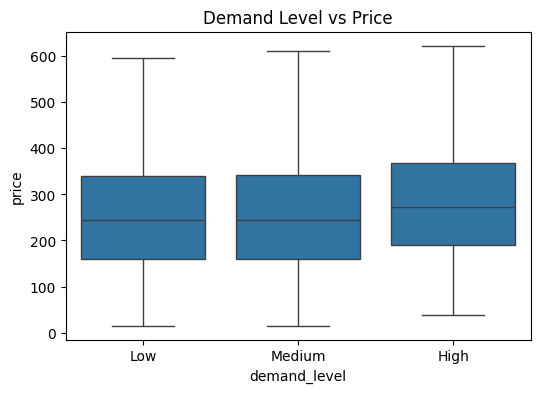

In [32]:
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=40, kde=True)
plt.title("Price Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="category", data=df)
plt.title("Category Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="demand_level", y="price", data=df)
plt.title("Demand Level vs Price")
plt.show()


In [33]:
label_encoders = {}

categorical_cols = ["medicine_name", "category", "company", "import_status", "demand_level"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [34]:
X = df.drop("price", axis=1)
y = df["price"]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [36]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [37]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "SVR": SVR(),
}


In [38]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
results_df.sort_values(by="R2", ascending=False)


,Model,MAE,RMSE,R2
0,Linear Regression,36.194759,45.208938,0.866831
2,Lasso,36.010755,45.210261,0.866823
1,Ridge,36.181777,45.210545,0.866821
6,Gradient Boosting,36.377720,45.850726,0.863023
5,Random Forest,37.547700,47.666894,0.851957
7,AdaBoost,39.142138,48.504111,0.846710
4,Decision Tree,48.717067,64.274969,0.730822
3,KNN,52.708020,66.113778,0.715200
8,SVR,61.613250,77.317716,0.610495


In [39]:
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

rf = RandomForestRegressor(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=1  # Windows-compatible
)

grid.fit(X_train_scaled, y_train)


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [2, 5], 'n_estimators': [100, 300]}"
,scoring,'r2'
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [40]:
best_model = grid.best_estimator_


In [41]:
preds = best_model.predict(X_test_scaled)

print("R2 Score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))


R2 Score: 0.8604814277658921
MAE: 37.11214416049134
RMSE: 46.27413363452869


In [42]:
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring="r2")
print("Cross Validation Mean R2:", cv_scores.mean())


Cross Validation Mean R2: 0.8553114223092914


In [43]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance


,Feature,Importance
5,manufacturing_cost,0.796183
6,import_status,0.184257
7,demand_level,0.017245
8,expiry_months,0.000782
1,category,0.000550
3,dosage_mg,0.000465
0,medicine_name,0.000234
2,company,0.000151
4,pack_size,0.000106
9,prescription_required,0.000029


In [44]:
joblib.dump(best_model, "medicine_price_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")


['label_encoders.pkl']

In [45]:
sample = X_test.iloc[[0]]
sample_scaled = scaler.transform(sample)
prediction = best_model.predict(sample_scaled)

print("Predicted Price:", prediction)


Predicted Price: [304.38371066]
